# PTMCMCSampler & Bayesian Analyses using the PTA Likelihood Function




In [116]:
import os, json, pickle

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as sps

import PTMCMCSampler.PTMCMCSampler as ptmcmc

from emcee.autocorr import integrated_time

import corner.corner as corner

`cloudpickle` is a Python package which allows dynamically constructed clases to be pickled, unlike `pickle`. `Enterprise` uses class factories to make different signal classes for each of the different pulsars in a PTA, hence in order to pickle the full PTA one needs `cloudpickle`. 

In [ ]:
# !conda install -c conda-forge cloudpickle
# or install from PyPI
# !pip install cloudpickle

In [2]:
import cloudpickle

The easiest way to make the PTAs needed for this exercise is to make them with the script below. You will have to run the script on the command line to ensure that you use the correct ennvironment. 

``` Python
python mk_pta_pkls.py 
```

Check to see that the two pickle files have been saved in this directory. 

In [4]:
!ls vandy_3psr_fullpta_*.pkl

vandy_3psr_fullpta_crn.pkl vandy_3psr_fullpta_gwb.pkl


If 2 different pickled files **don't** appear in this directory then you can alterantively copy/paste the script in `./mk_pta_pkls.py` in the cell below and delete the lines that pickle the 2 PTAs. We will need both loaded for the exercises below.

In [ ]:
# for explicit pta class production if needed. 

In [5]:
with open('./vandy_3psr_fullpta_crn.pkl','rb') as fin:
    pta_crn = cloudpickle.load(fin)
    
with open('./vandy_3psr_fullpta_gwb.pkl','rb') as fin:
    pta_gwb = cloudpickle.load(fin)

### test the log-likelihoods and log-priors!

In [121]:
# generate a random point
x0 = {pp.name:pp.sample() for pp in pta_gwb.params}

In [7]:
# calculate logL and logPr
print('GWB PTA: ',pta_gwb.get_lnlikelihood(x0), pta_gwb.get_lnprior(x0))
print('CRN PTA: ',pta_crn.get_lnlikelihood(x0), pta_crn.get_lnprior(x0))

GWB PTA:  224610.04708000974 -26.245102719469088
CRN PTA:  224610.16744500655 -26.245102719469088


## The Challenges of the PTA Likelihood Function
There are a number of reasons why it's challenging to sample your way to a reasonable posterior or evidence with starting from a PTA likelihood:

1. The continual growth of PTA datasets and the need to do full dataset cross-correlation calculations slows down the likelihood evalution. See Steve's talk from yesterday for scaling of the likelihood evaluation.
2. Large parameter spaces combined with slow likelihood evaluations considerably slows down the amount of time to convergence.
3. Lack of derivative information from `enterprise` functions makes the use of Hamiltonian Monte Carlo techniques challenging.
4. Always remember that things are this slow and we are _marginalizing over the timing model_ and _setting the white noise parameters constant_! (i.e. stay humble and keep looking for better ways to sample :-)

Please keep looking and testing new algorithms and samplers as the appear in the literature and in the open source code community!!

## Parameter Estimation

### MCMC

`enterprise_extensions.sampler.setup_sampler()` returns a `PTMCMCSampler` object.
The MCMC sampler can be tuned to improve performance.
The defaults of `setup_sampler` are often fine, but suboptimal.
One can fine improved acceptance and convergence, but adjusting the inputs to `setup_sampler` or setting up the sampler __manually__.

In [127]:
import enterprise_extensions.sampler as Sampler
from enterprise_extensions.sampler import JumpProposal as jp

In [124]:
pta_crn.param_names

['J1600-3053_dm_gp_gamma',
 'J1600-3053_dm_gp_log10_A',
 'J1600-3053_red_noise_gamma',
 'J1600-3053_red_noise_log10_A',
 'J2241-5236_band_noise_20CM_gamma',
 'J2241-5236_band_noise_20CM_log10_A',
 'J2241-5236_dm_gp_gamma',
 'J2241-5236_dm_gp_log10_A',
 'J2241-5236_red_noise_gamma',
 'J2241-5236_red_noise_log10_A',
 'J2317+1439_red_noise_gamma',
 'J2317+1439_red_noise_log10_A',
 'gw_log10_A']

In [123]:
ndim = len(pta_crn.param_names)
cov_new = np.diag(np.ones(ndim) * 0.1**2)
groups = [[0,1],[2,3],[0,1,2,3],[4,5],]
sampler0 = ptmcmc.PTSampler(ndim=ndim,
                            logl=pta_crn.get_lnlikelihood,
                            logp=pta_crn.get_lnprior,
                            cov=cov_new,
                            groups = groups,
                            outDir='chains0/')

`PTMCMCSampler` contains a few built-in jump proposals including:
```
AM => Adaptive Metroplis
SCAM => Single Component Adaptive Metroplis
DE => Differential Evolution
```
The first two use the covariance matrix, which is iteratively recalculated, to make predictions about various parameters. The groups are used by the `AM` proposals. 

In [131]:
JP = jp(pta_crn)
sampler0.addProposalToCycle(JP.draw_from_gwb_log_uniform_distribution, 40)

In [132]:
# generate an initial sample and run the sampler!
p0 = np.hstack(list(x0.values()))

In [133]:
B = 5_000
T = 2
Nsamp = 20_000

N = T*Nsamp

In [134]:
sampler0.sample(p0,
                Niter=N,
                thin=T,
                burn=B)

/Users/hazboun/anaconda3/envs/ng15yr/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 12.50 percent in 10.463707 s Acceptance rate = 0.3244Adding DE jump with weight 20
Finished 97.50 percent in 72.016354 s Acceptance rate = 0.177596
Run Complete


### `enterprise_extensions` sampler

Check the output to see what is generated and plot a trace of the log-Posterior

* set the output directory
* specify yourself as the "human" running the job

* remember the sampler takes a `numpy.ndarray` for the starting location, not a `dict`

* set `burn=5000` (the DE buffer) DO NOT confuse with the usual use of `burn`
* set `thin=2` (save every other sample)
* collect `20000` samples (if we thin by 2, we'll need to run for `Niter=40000`!)

In [10]:
# setup the sampler
sampler = Sampler.setup_sampler(pta_crn, outdir='crn_pta', human="jsh")

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding GWB uniform distribution draws...



In [11]:
sampler.sample(p0,
               Niter=N,
               burn=B,
               thin=T)

/Users/hazboun/anaconda3/envs/ng15yr/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 12.50 percent in 11.301352 s Acceptance rate = 0.348Adding DE jump with weight 20
Finished 97.50 percent in 90.481811 s Acceptance rate = 0.341718
Run Complete


### Jump Proposals
One can add more jump proposals. The `JumpProposal` class is available to use for more various new proposals.

In [66]:
def draw_from_band_noise_prior(self, x, iter, beta):

        q = x.copy()
        lqxy = 0

        # draw parameter from signal model
        name = 'band_noise'
        par = np.random.choice([p for p in self.pnames if name in p])
        idx = list(self.pnames).index(par)
        param = self.params[idx]

        q[self.pmap[str(param)]] = np.random.uniform(param.prior._defaults['pmin'], param.prior._defaults['pmax'])

        # forward-backward jump probability
        lqxy = (param.get_logpdf(x[self.pmap[str(param)]]) -
                param.get_logpdf(q[self.pmap[str(param)]]))

        return q, float(lqxy)

In [67]:
sampler2 = Sampler.setup_sampler(pta_crn, outdir="crn_pta_jp", human="jsh")

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding GWB uniform distribution draws...



**Note:** Below we are changing the generic `Sampler` class not just an instance of the class by adding this new jump proposal as an attribute.

In [68]:
Sampler.JumpProposal.draw_from_band_noise_prior = draw_from_band_noise_prior

In [69]:
sampler2.addProposalToCycle(sampler2.jp.draw_from_band_noise_prior, 40) # Number is the relative weight of proposal

In [70]:
sampler2.jp.snames

{'dm_gp': [J2241-5236_dm_gp_gamma:Uniform(pmin=0, pmax=7),
  J2241-5236_dm_gp_log10_A:Uniform(pmin=-20, pmax=-11),
  J1600-3053_dm_gp_log10_A:Uniform(pmin=-20, pmax=-11),
  J1600-3053_dm_gp_gamma:Uniform(pmin=0, pmax=7)],
 'ecorr_sherman-morrison': [],
 'marginalizing linear timing model': [],
 'measurement_noise': [],
 'red noise': [J2241-5236_red_noise_gamma:Uniform(pmin=0, pmax=7),
  J2241-5236_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
  J2241-5236_band_noise_20CM_gamma:Uniform(pmin=0, pmax=7),
  J2241-5236_band_noise_20CM_log10_A:Uniform(pmin=-20, pmax=-11),
  J2317+1439_red_noise_gamma:Uniform(pmin=0, pmax=7),
  J1600-3053_red_noise_gamma:Uniform(pmin=0, pmax=7),
  J2317+1439_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
  gw_log10_A:Uniform(pmin=-18, pmax=-14),
  J1600-3053_red_noise_log10_A:Uniform(pmin=-20, pmax=-11)]}

In [71]:
sampler2.sample(p0,
                Niter=N,
                burn=B,
                thin=T)

/Users/hazboun/anaconda3/envs/ng15yr/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 12.50 percent in 10.895575 s Acceptance rate = 0.3278Adding DE jump with weight 20
Finished 97.50 percent in 79.921336 s Acceptance rate = 0.338949
Run Complete


### Empirical Distributions
_Empirical distributions_ are probablity density functions based on samples from a previous MCMC analysis. Here we will use the noise runs done bye Paul Baker to obtain the white noise parameters that are being set constant.

In [72]:
from enterprise_extensions.empirical_distr import make_empirical_distributions

In [86]:
import la_forge.slices as sl
import la_forge.core as co
import la_forge.diagnostics as dg

In [73]:
!tar -xzf viper_3psr_noiseruns.tgz

In [95]:
to_get = []

for psr in pta_crn.pulsars:
    to_get.append([par for par in pta_crn.param_names if psr in par and 'J1600-3053_dm_gp' not in par])
    
slc = sl.SlicesCore(slicedirs=pta_crn.pulsars,
                    pars2pull=to_get,params=[it for sub in to_get for it in sub ])

J2317+1439/chain_1.txt is loaded.



In [96]:
params2d = []
for ii in range(int(len(slc.params)//2)):
    params2d.append([slc.params[ii],slc.params[ii+1]])
    
params2d

[['J1600-3053_red_noise_gamma', 'J1600-3053_red_noise_log10_A'],
 ['J1600-3053_red_noise_log10_A', 'J2241-5236_band_noise_20CM_gamma'],
 ['J2241-5236_band_noise_20CM_gamma', 'J2241-5236_band_noise_20CM_log10_A'],
 ['J2241-5236_band_noise_20CM_log10_A', 'J2241-5236_dm_gp_gamma'],
 ['J2241-5236_dm_gp_gamma', 'J2241-5236_dm_gp_log10_A']]

In [97]:
make_empirical_distributions(pta_crn,
                             paramlist=params2d,# List of 2 element lists to make 2d emp dists
                             params=slc.params, #List of params in chain array
                             chain=slc.chain,
                             filename='viper_3psr_pta_emp_distr.pkl')

In [98]:
sampler3 = Sampler.setup_sampler(pta_crn, 
                                 outdir="crn_pta_ed", 
                                 human="jsh",
                                 empirical_distr='viper_3psr_pta_emp_distr.pkl')

Extending empirical distributions to priors...

Attempting to add empirical proposals...

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding GWB uniform distribution draws...



In [99]:
sampler3.sample(
    p0, Niter=N,
    burn=B, thin=T
)

/Users/hazboun/anaconda3/envs/ng15yr/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 12.50 percent in 11.314550 s Acceptance rate = 0.3197Adding DE jump with weight 20
Finished 97.50 percent in 80.438042 s Acceptance rate = 0.313026
Run Complete


In [102]:
cCRN = co.Core(chaindir="crn_pta")
cCRN2 = co.Core(chaindir="crn_pta_jp")
cCRN3 = co.Core(chaindir="crn_pta_ed")

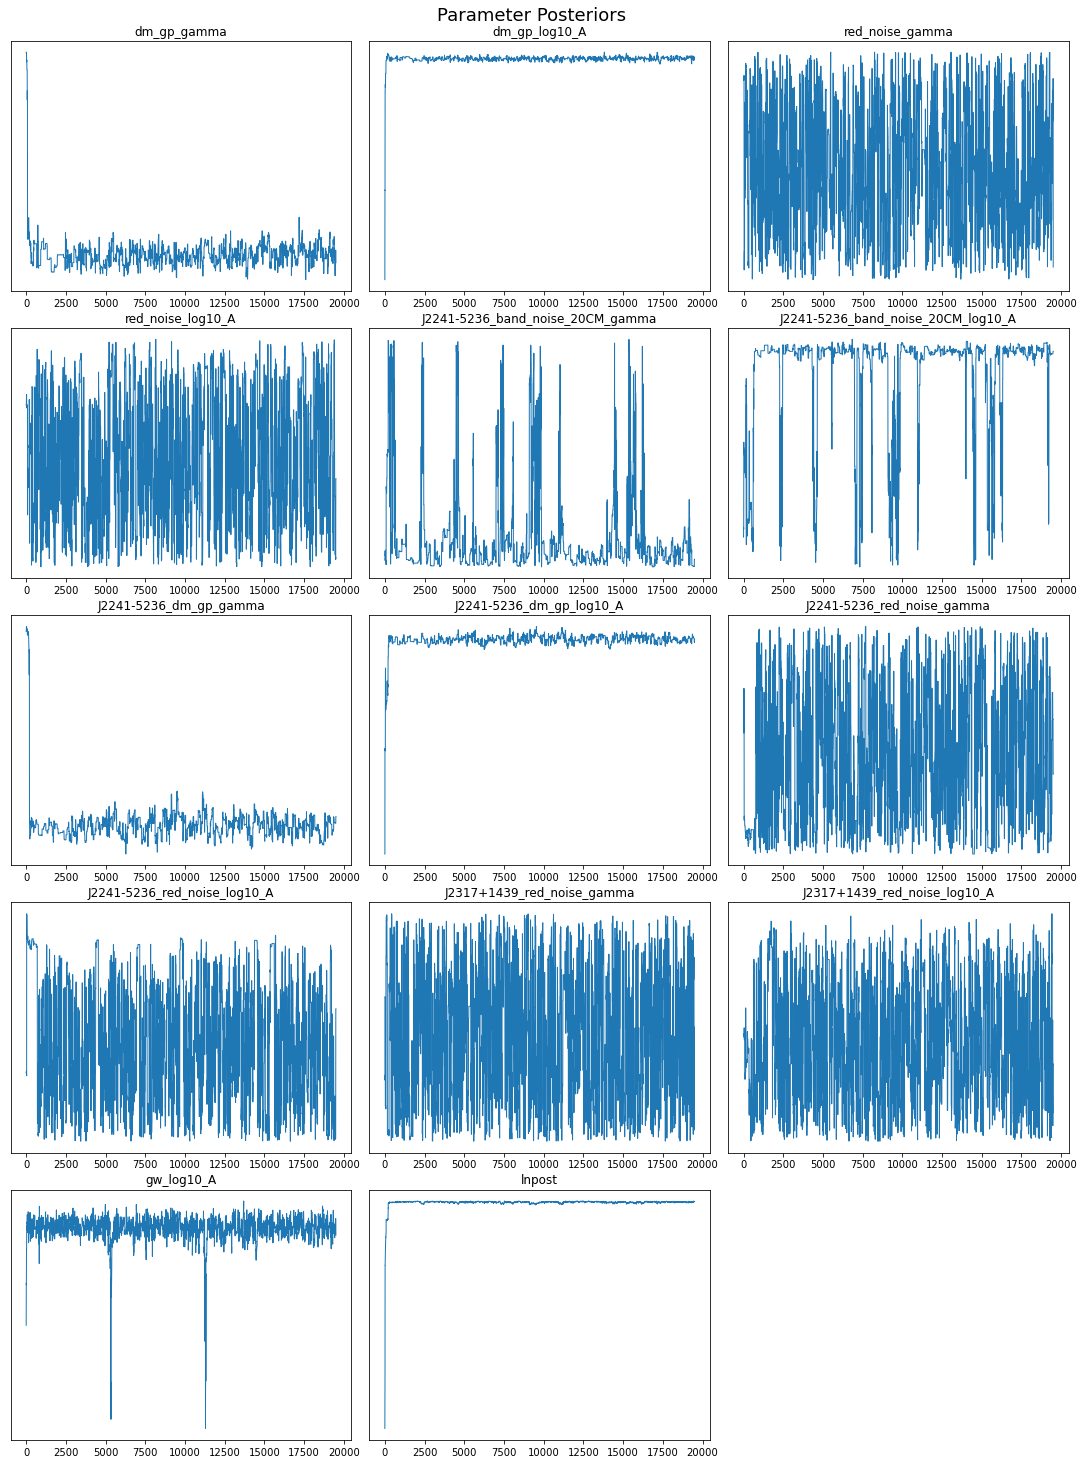

In [44]:
cCRN.set_burn(0)
dg.plot_chains(cCRN,hist=False,exclude=['lnlike','chain_accept','pt_chain_accept'])

N/50 = 292;
tau: [314.32561262]
N/50 = 292;
tau: [399.86973677]
N/50 = 292;
tau: [456.99148384]
N/50 = 292;
tau: [551.77300172]
N/50 = 292;
tau: [504.68298379]


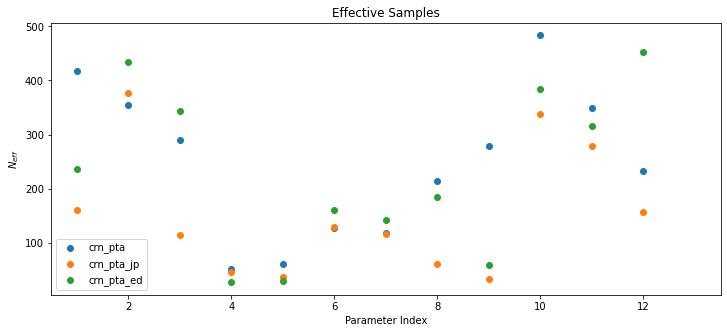

In [104]:
cCRN.set_burn(0.25)
plot_neff([cCRN,cCRN2,cCRN3])

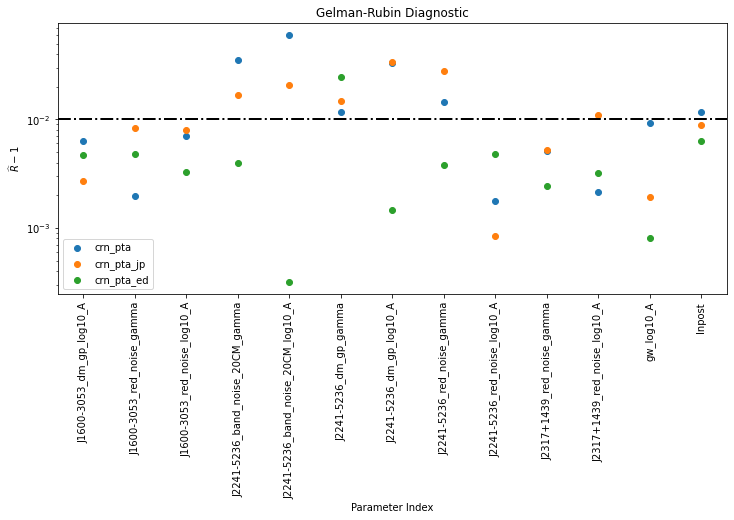

In [103]:
plot_grubin([cCRN,cCRN2,cCRN3])

In [38]:
cCRN.params

['J1600-3053_dm_gp_gamma',
 'J1600-3053_dm_gp_log10_A',
 'J1600-3053_red_noise_gamma',
 'J1600-3053_red_noise_log10_A',
 'J2241-5236_band_noise_20CM_gamma',
 'J2241-5236_band_noise_20CM_log10_A',
 'J2241-5236_dm_gp_gamma',
 'J2241-5236_dm_gp_log10_A',
 'J2241-5236_red_noise_gamma',
 'J2241-5236_red_noise_log10_A',
 'J2317+1439_red_noise_gamma',
 'J2317+1439_red_noise_log10_A',
 'gw_log10_A',
 'lnpost',
 'lnlike',
 'chain_accept',
 'pt_chain_accept']

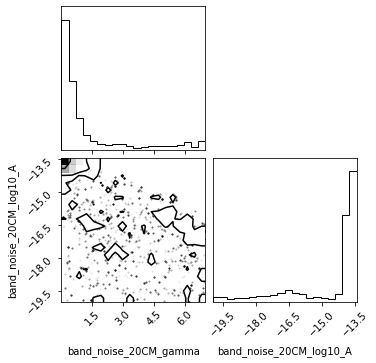

In [106]:
band_pars = ['J2241-5236_band_noise_20CM_gamma','J2241-5236_band_noise_20CM_log10_A']


corner(cCRN3(band_pars),labels=[p.replace('J2241-5236_','') for p in band_pars])
plt.show()

## Product Space Sampling with the `HyperModel` submodule

[Product space sampling](https://academic.oup.com/mnras/article/455/3/2461/1069531) allows one to calculate Bayes factors without using the Savage-Dickey approximation or calculating evidences or posterior odds ratios. Multiple models are concatenated into one large HyperModel along with a model parameter which selects which model likelihood is evaluated in each iteration. The relative number of samples in for the `nmodel` parameter can be interpreted as the odds ratio between the models.

In [107]:
from enterprise_extensions.hypermodel import HyperModel

In [108]:
ptas = {0:pta_crn,1:pta_gwb}

In [109]:
hm = HyperModel(ptas)

**Note:** The `log_weights` flag can be used to put models on an even footing when one model is preferred over another.

In [113]:
hsampler = hm.setup_sampler(outdir='hypermodel',empirical_distr='viper_3psr_pta_emp_distr.pkl',human='jsh')

Extending empirical distributions to priors...

Adding empirical proposals...

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



/Users/hazboun/anaconda3/envs/ng15yr/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [114]:
x0 = hm.initial_sample()
hsampler.sample(x0,
                Niter=N,
                burn=B,
                thin=T)

/Users/hazboun/anaconda3/envs/ng15yr/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 12.50 percent in 34.336820 s Acceptance rate = 0.37925Adding DE jump with weight 20
Finished 97.50 percent in 258.626352 s Acceptance rate = 0.393308
Run Complete


# Things to work on during the hack time

You don't need to do all of these, and you don't need to do them in order.  Pick one (or more) to try.
MCMC's can take a **long** time to run.  You may want to set up a notebook, then wait to run it overnight.

While the MCMC is running you can use the post processing notebook and read in the samples using `la_forge` to check on progress.
The number of samples it will take to have well converged posteriors will depend on the specific model.
Using these settings in `sampler.sample` will run for 100k samples, saving every tenth.
That may be enough...
* `Niter=100_000`
* `burn=20_000`
* `thin=10`
Models with more parameters will require more samples to converge.


## questions:

* What changes to the "vanilla" sampler can be made to get better convergence?
* Do the proposal acceptances change when new proposals are added into the mix?
* If a model is weighted in the `HyperModel` class how does one "unweight" the models to compare the odds ratios?


## ideas:

* Try parallel tempering on the same `CRN` model above and compare the Gelman-Rubin statistic and autocorrelation lengths given the same number of samples. 

* Use the `HyperModel` class to find the odds ratio for a common red process versus a model _without_ any common signal, correlated or otherwise. You will need to edit the script that makes `PTA` classes by building a PTA without a common signal. 

* Choose another sampler, e.g.,[dynesty](), [ultranest](), [zeus](https://zeus-mcmc.readthedocs.io/en/latest/), [emcee](https://emcee.readthedocs.io/en/stable/)... (**Note:** These will not work easily for full PTAs, but should work on the simplified examples used above.)

* Pull recent public data from your favorite PTA and set up a `PTA` object to perform an **analysis of your choice**.  Here are `.pkl` files containing a list of `enterprise` `Pulsar` objects for three recent data releases:
 * [EPTA 6PSR](https://drive.google.com/file/d/1MyZX7ox_8TlRUhgk47NirNYcWfEz5ron/view?usp=sharing)
 * [PPTA DR2](https://drive.google.com/file/d/1at5S_ydfqGV2x0PzF4eCO_BXhQjfamKX/view?usp=sharing)
 * [NANOGrav 12.5y](https://drive.google.com/file/d/1eWNLgPOm7mYKAt3LYY_YIb1i19_n03xD/view?usp=sharing)

## Parallel Tempering
`PTMCMCSampler` has [PT functionality](https://academic.oup.com/gji/article/196/1/357/585739) available, but one needs to use MPI (Message Passing Interface), which is not compatible with Jupyter notebooks, in order to use it. If your laptop has multiple cores, or you have access to a cluster you can try a PT run. First you need to write a Python script (hint: start by converting this notebook into a script using `jupyter nbconvert --to=script sampling_the_enterprise_likelihood.ipynb`.) Second you would use the following command 
```
mpiexec -np 4 python your_script.py
```
The `-np 4` tells MPI to use 4 cores. You can change this number if you'd like. When the sampler detectes that there is an MPI environment it will automatically initiate parallel tempering. I'd recommend setting the `sampler.sample` flag `writeHotChains=True`, which will write the hot chains to disk. This is useful for knowing that PT is actually working. 